In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import time
import datetime

import pickle
import gc

from tqdm import tqdm

n_fold = 7
seed0 = 8586
use_supple_for_train = True

# If True, the period used to evaluate Public LB will not be used for training.
# Set to False on final submission.
not_use_overlap_to_train = False

TRAIN_CSV = './train.csv'
SUPPLE_TRAIN_CSV = './supplemental_train.csv'
ASSET_DETAILS_CSV = './asset_details.csv'


pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 350)

In [3]:
df_asset_details = pd.read_csv(ASSET_DETAILS_CSV).sort_values("Asset_ID")
df_train = pd.read_csv(TRAIN_CSV, index_col='timestamp')

if use_supple_for_train:    
    df_supple = pd.read_csv(SUPPLE_TRAIN_CSV, index_col='timestamp')
#     display(df_supple)
    df_train = pd.concat([df_train, df_supple])
    del df_supple

In [4]:
df_ls=[]
for id in tqdm( range(14) ):
    df = df_train.loc[df_train["Asset_ID"] == id]
    df = df.dropna(subset='Target')
    df = df.reindex(range(df.index[0],df.index[-1]+60,60),method='pad')
    df['VWAP'] = df['VWAP'].replace([np.inf, -np.inf], np.nan)
    df = df.ffill()
    df_ls.append(df)
train = pd.concat(df_ls)
train.index = pd.to_datetime(train.index, unit='s')
train = train.sort_index(ascending=True)
train

100%|██████████| 14/14 [00:13<00:00,  1.01it/s]


,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
2018-01-01 00:01:00,0,5.0,8.530000,8.530000,8.530000,8.530000,78.380000,8.530000,-0.014399
2018-01-01 00:01:00,2,40.0,2376.580000,2399.500000,2357.140000,2374.590000,19.233005,2373.116392,-0.004218
2018-01-01 00:01:00,5,32.0,7.659600,7.659600,7.656700,7.657600,6626.713370,7.657713,-0.013922
2018-01-01 00:01:00,6,173.0,738.302500,746.000000,732.510000,738.507500,335.987856,738.839291,-0.004809
2018-01-01 00:01:00,7,5.0,25.920000,25.920000,25.874000,25.877000,121.087310,25.891363,-0.008264
...,...,...,...,...,...,...,...,...,...
2022-01-23 23:44:00,12,177.0,0.199714,0.200072,0.199476,0.199952,195146.286204,0.199805,-0.001046
2022-01-23 23:44:00,8,100.0,0.808633,0.814500,0.807800,0.809600,7257.334540,0.810353,0.000070
2022-01-23 23:44:00,4,126.0,0.140948,0.141140,0.140700,0.140945,566910.831017,0.140933,0.001127


# Feature Enginnering

In [5]:
import pandas as pd
import numpy as np
from numba import njit
from tqdm import tqdm

@njit
def abs_snr(returns_window):
    if len(returns_window) == 0:
        return np.nan
    
    returns_sum = 0.0
    abs_sum = 0.0
    
    for r in returns_window:
        returns_sum += r
        abs_sum += abs(r)
    
    if abs_sum < 1e-6:
        return 0.0
    
    return returns_sum / abs_sum

@njit
def rsi(x):
    gains = 0.0
    losses = 0.0
    for i in range(1, len(x)):
        diff = x[i] - x[i-1]
        if diff > 0:
            gains += diff
        else:
            losses -= diff  # 取正值

    avg_gain = gains / (len(x)-1)
    avg_loss = losses / (len(x)-1)
    
    if avg_loss == 0:
        return 100.0
    rs = avg_gain / avg_loss
    rsi = 100.0 - (100.0 / (1.0 + rs))
    return rsi

def get_fe(train):
    # 添加验证窗口标记
    valid_window = pd.to_datetime("2021-12-03")
    train['train_flg'] = np.where(train.index >= valid_window, 1, 0)
    
    processed_dfs = []
    
    # 对每个资产单独处理
    for asset_id in tqdm(range(14), desc='计算时序因子'):
        df = train[train['Asset_ID'] == asset_id].copy()
        
        ################### 时序因子 ###################
        # 基础价格因子（向量化操作，无需numba）
        df['intra_minute_range'] = (df['High'] - df['Low']) / df['Open']
        df['close_open_ratio'] = df['Close'] / df['Open']
        df['price_vwap_premium'] = df['Close'] / df['VWAP'] - 1
        
        # 价格与移动平均（使用ewm加速）
        for window in [5, 10, 20, 50]:
            df[f'price_ema_ratio_{window}'] = df['Close'] / df['Close'].ewm(span=window).mean()
            
        # 均线差异占比（向量化操作）
        df['price_ema_diff_fast'] = (df['price_ema_ratio_10'] - df['price_ema_ratio_20']) /\
                                   (abs(df['price_ema_ratio_10'] - df['price_ema_ratio_20'])+abs(df['price_ema_ratio_20'] - df['price_ema_ratio_50'])+ 1e-6)
        df['price_ema_diff_slow'] = (df['price_ema_ratio_20'] - df['price_ema_ratio_50']) / \
                                   (abs(df['price_ema_ratio_10'] - df['price_ema_ratio_20'])+abs(df['price_ema_ratio_20'] - df['price_ema_ratio_50'])+ 1e-6)
        
        # 趋势加速度因子
        df['trend_accel_5'] = df['price_ema_ratio_5'] / df['price_ema_ratio_10']
        df['trend_accel_10'] = df['price_ema_ratio_10'] / df['price_ema_ratio_20']

        # 价格变化与波动率的比值
        returns = df['Close'].pct_change().values
        for window in [5, 10, 20]:
            vol = pd.Series(returns).rolling(window).std().values
            df[f'normalized_change_{window}'] = np.where(vol == 0, 0, returns / (vol + 1e-6))

        # 单位交易量的价格变动
        df['price_change_per_volume'] = np.where(
            df['Count'] == 0, 0, 
            (df['Close'] - df['Open']) / (df['Count'] + 1e-6)
        )
        for window in [5, 10, 20]:
            df[f'price_change_per_volume_ma_{window}'] = df['price_change_per_volume'].rolling(window).mean()

        # 信噪比
        for window in [5, 10, 20, 50]:
            returns = df['Close'].pct_change()
            df[f'abs_snr_{window}'] = returns.rolling(window).apply(abs_snr, engine='numba', raw=True)

        # 成交量与历史平均的比值
        for window in [5, 10, 20, 50]:
            df[f'volume_ratio_{window}'] = df['Volume'] / df['Volume'].rolling(window).mean()
        
        # 量价背离因子
        df['volume_price_divergence'] = df['volume_ratio_10'] * (1 - df['price_ema_ratio_10'])

        # 均线突破信号
        df['ma_cross_above_5_20'] = (
            (df['Close'].rolling(5).mean() > df['Close'].rolling(20).mean()) & 
            (df['Close'].rolling(5).mean().shift(1) <= df['Close'].rolling(20).mean().shift(1))
        ).astype(int)
        
        # 布林带突破信号
        for window in [10, 20]:
            ma = df['Close'].rolling(window).mean()
            std = df['Close'].rolling(window).std()
            df[f'bollinger_break_upper_{window}'] = (df['Close'] > ma + 2*std).astype(int)
            df[f'bollinger_break_lower_{window}'] = (df['Close'] < ma - 2*std).astype(int)

        # K线形态信号（向量化操作）
        candle_range = df['High'] - df['Low'] + 1e-6
        df['strong_bull_candle'] = ((df['Close'] - df['Open']) / candle_range > 0.7).astype(int)
        df['strong_bear_candle'] = ((df['Open'] - df['Close']) / candle_range > 0.7).astype(int)
        df['doji_candle'] = (abs(df['Close'] - df['Open']) / candle_range < 0.1).astype(int)

        # RSI指标（使用numba加速）
        for window in [5, 10, 20, 50]:
            df[f'rsi_{window}'] = df['Close'].rolling(window).apply(rsi, engine='numba', raw=True)
            
        # 量价相关性
        df['volume_price_corr'] = df['Close'].rolling(30).corr(df['Volume'])

        # 波动率聚集效应
        returns = df['Close'].pct_change()
        df['volatility_clustering'] = (
            pd.Series(returns).rolling(10).std() / 
            pd.Series(returns).rolling(30).std()
        )
        
        processed_dfs.append(df[50:])
    
    # 合并所有资产数据
    factor = pd.concat(processed_dfs).sort_index()
    
    
    ################### 截面因子 ###################
    # 收益率截面排名
    # windows = [1, 10, 20, 50]
    # for i in tqdm(range(len(windows)), desc= '计算收益率截面排名'):
    #     # 计算各资产的收益率
    #     window = windows[i]
    #     ret_col = f'ret_{window}day'
    #     factor[ret_col] = factor.groupby('Asset_ID')['Close'].pct_change(window)
        
    #     # 按时间戳分组计算截面排名
    #     factor[f'cross_rank_ret_{window}day'] = factor.groupby('timestamp')[ret_col].transform(
    #         lambda x: x.rank(pct=True, na_option='keep')
    #     )
        
    #     # 移除临时列
    #     factor.drop(ret_col, axis=1, inplace=True)

    # 成交量与移动平均比值排名
    # for window in [5, 20, 50]:
    #     vol_ratio_col = f'volume_ratio_{window}'
        
    #     # 确保该列存在
    #     if vol_ratio_col not in factor.columns:
    #         # 如果不存在，创建它
    #         factor[vol_ratio_col] = factor.groupby('Asset_ID')['Volume'].transform(
    #             lambda x: x / x.rolling(window).mean()
    #         )
        
    #     # 计算截面排名
    #     factor[f'cross_rank_volume_ma_{window}'] = factor.groupby('timestamp')[vol_ratio_col].transform(
    #         lambda x: x.rank(pct=True, na_option='keep')
    #     )
    
    # 填充缺失值
    # factor = factor.fillna(method='ffill').fillna(0)
    
    return factor

In [6]:
factor = get_fe(train)
factor['volume_price_corr'] = factor['volume_price_corr'].fillna(0)
factor['volatility_clustering'] = factor['volatility_clustering'].fillna(0)
factor['volume_price_corr'] = np.where(abs(factor['volume_price_corr'])>1, 0, factor['volume_price_corr'])

计算时序因子: 100%|██████████| 14/14 [01:06<00:00,  4.72s/it]


In [ ]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
desc = factor.describe().T
# factor['volume_price_corr'].min()

In [ ]:
formatters = {
    'count': lambda x: '{:,.0f}'.format(x),
    'min': lambda x: '{:,.0f}'.format(x) if x == int(x) else '{:.3f}'.format(x),
    '25%': lambda x: '{:,.0f}'.format(x) if x == int(x) else '{:.3f}'.format(x),
    '50%': lambda x: '{:,.0f}'.format(x) if x == int(x) else '{:.3f}'.format(x),
    '75%': lambda x: '{:,.0f}'.format(x) if x == int(x) else '{:.3f}'.format(x),
    'max': lambda x: '{:,.0f}'.format(x) if x == int(x) else '{:.3f}'.format(x),
    # 其余默认保留3位小数
    'mean': '{:.3f}'.format,
    'std': '{:.3f}'.format,
}

print(desc.to_latex(index=True, formatters=formatters, escape=False))

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import gc
from lightgbm import LGBMRegressor, early_stopping, log_evaluation
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit

# ================================
# 1️⃣ Helper Functions
# ================================

def corr_score(pred, valid):
    pred = np.array(pred)
    valid = np.array(valid)
    pred = (pred - pred.mean()) / pred.std()
    valid = (valid - valid.mean()) / valid.std()
    return np.mean(pred * valid)

def wcorr_score(pred, valid, weight):
    len_data = len(pred)
    sum_w = np.sum(weight)
    mean_pred = np.sum(pred * weight) / sum_w
    mean_valid = np.sum(valid * weight) / sum_w
    var_pred = np.sum(weight * np.square(pred - mean_pred)) / sum_w
    var_valid = np.sum(weight * np.square(valid - mean_valid)) / sum_w

    cov = np.sum((pred * valid * weight)) / sum_w - mean_pred * mean_valid
    corr = cov / np.sqrt(var_pred * var_valid)

    return corr

def plot_importance(importances, features_names, top=20, figsize=(15, 10), save_path=None):
    importance_df = pd.DataFrame(data=importances, columns=features_names)
    sorted_indices = importance_df.median(axis=0).sort_values(ascending=False).index.to_list()
    sorted_importance_df = importance_df.loc[:, sorted_indices]
    plot_cols = sorted_importance_df.columns[:top]
    _, ax = plt.subplots(figsize=figsize)
    ax.grid()
    ax.set_xscale('log')
    ax.set_ylabel('Feature')
    ax.set_xlabel('Importance')
    sns.boxplot(data=sorted_importance_df[plot_cols],
                orient='h',
                ax=ax)
    plt.tight_layout()
    
    if save_path is not None:
        plt.savefig(save_path, dpi=300)
        print(f"    Feature importance plot saved to {save_path}")
    else:
        plt.show()
    plt.close()



# ================================
# 2️⃣ Main Parameters
# ================================
n_fold=5
embargo=3750
train_params = {
    'early_stopping': 5,
}
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'max_depth': -1,
    'min_child_samples': 200,
    'reg_alpha': 1.0,
    'reg_lambda': 5.0,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 1,
    'verbose': -1,
    'bagging_seed':42,
    'n_estimators': 500,
    'device_type': 'gpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
    'max_bin': 255,
    'num_threads': 16,
    'seed': 42,
}


# 你的特征列，去掉不需要的
features = factor.columns.drop(['Asset_ID', 'Target', 'train_flg', 'Count', 'Open', 'High', 'Low', 'Close', 'Volume', 'VWAP']).tolist()
for col in features:
    if pd.api.types.is_integer_dtype(factor[col]):
        factor[col] = factor[col].astype('category')
# ================================
# 3️⃣ Training Loop per Asset (with 5 fold Ensemble on Test Set)
# ================================

oof = []
all_oof_pred = []
all_oof_valid = []
all_oof_weight = []

all_test_pred = []
all_test_valid = []
all_test_weight = []

# 创建总model目录
os.makedirs('model', exist_ok=True)

# 额外收集所有asset的importances
all_importances = []
best_iterations = {}

for asset_id, asset_name in zip(df_asset_details['Asset_ID'], df_asset_details['Asset_Name']):
    print(f"Training model for {asset_name:<16} (ID={asset_id:<2})")
    
    # 只取当前资产数据，排序
    df_asset = factor[factor['Asset_ID'] == asset_id].copy()
    df_asset = df_asset.sort_index()

    df_train = df_asset.loc['2018-01-01': '2021-06-01']
    df_test = df_asset.loc['2021-06-01':]

    X_test_final = df_test[features]
    y_test_final = df_test['Target']

    # 存储
    importances = []
    oof_pred = []
    oof_valid = []

    tscv = TimeSeriesSplit(n_splits=n_fold)
    
    # 为当前Asset创建目录
    asset_model_dir = f'/mnt/T0/zxy/result/kaggle/model/{asset_name}'
    os.makedirs(asset_model_dir, exist_ok=True)

    # 记录当前 asset 5 fold 模型
    models = []

    for fold, (train_index, valid_index) in enumerate(tscv.split(df_train)):
        print(f"Fold {fold}")
        weight_temp = float(df_asset_details.loc[df_asset_details['Asset_ID'] == asset_id, 'Weight'].iloc[0])

        train_split = df_train.iloc[train_index]
        X_train_split = train_split[features]
        y_train_split = train_split['Target']
        X_valid_split = train_split[features][embargo:]
        y_valid_split = train_split['Target'][embargo:]

        # 训练模型
        model = LGBMRegressor(**params)
        model.fit(
            X_train_split, y_train_split,
            eval_set=[(X_valid_split, y_valid_split)],
            eval_metric='rmse',
            callbacks=[
                early_stopping(stopping_rounds=train_params['early_stopping'], verbose=True),
                log_evaluation(period=0)
            ]
        )
        
        # 保存 feature importance
        importances.append(model.booster_.feature_importance(importance_type='gain'))
        if fold == n_fold-1:
            best_iterations[asset_name]=model.best_iteration_
        # OOF 预测
        y_pred_split = model.predict(X_valid_split)
        oof_pred += list(y_pred_split)
        oof_valid += list(y_valid_split.to_numpy())

        # 保存当前 fold 模型
        file = os.path.join(asset_model_dir, f'fold_{fold}.pkl')
        pickle.dump(model, open(file, 'wb'))
        print(f"    Model saved to {file}")

        # 存储模型
        models.append(model)

    # 当前资产 feature importance 不单独画 → 收集
    all_importances += importances
    score = corr_score(np.array(oof_pred), np.array(oof_valid))
    print(f'  valid corr score of {asset_name} (ID={asset_id}) is {score:.5f}. (Weight: {weight_temp:.5f})')

    # 存储整体 OOF
    all_oof_pred += oof_pred
    all_oof_valid += oof_valid
    all_oof_weight += [weight_temp] * len(oof_pred)

    oof.append(score)

    # fold 递增权重
    fold_weights = np.arange(1, len(models)+1)  # [1, 2, 3, 4, 5]
    y_test_preds = []
    for model in models:
        y_test_preds.append(model.predict(X_test_final))
    y_test_preds = np.array(y_test_preds)  # shape: [n_models, n_test_samples]
    y_test_pred_ensemble = np.average(y_test_preds, axis=0, weights=fold_weights)


    test_score = corr_score(y_test_pred_ensemble, y_test_final.values)
    print(f'  test corr score of {asset_name} (ID={asset_id}) is {test_score:.5f}. (Weight: {weight_temp:.5f})')

    # 存储整体 TEST
    all_test_pred += list(y_test_pred_ensemble)
    all_test_valid += list(y_test_final.values)
    all_test_weight += [weight_temp] * len(y_test_pred_ensemble)

# ================================
# 4️⃣ Overall Results
# ================================

# Wcorr on OOF
all_oof_wcorr = wcorr_score(np.array(all_oof_pred), np.array(all_oof_valid), np.array(all_oof_weight))
print(f'        weighted OOF corr score: {all_oof_wcorr:.5f}')

# Overall TEST wcorr
test_woof = wcorr_score(np.array(all_test_pred), np.array(all_test_valid), np.array(all_test_weight))
print(f'        FINAL TEST weighted corr score: {test_woof:.5f}')

# ✅ Plot Overall Feature Importance (Mean of All Assets)
feature_importance_plot_path = 'model/feature_importance.png'
plot_importance(np.array(all_importances), features, top=20, figsize=(15, 10), save_path=feature_importance_plot_path)



# ==========================================
# 5️⃣ Final Model with Full Train Set
# ==========================================
y_pred=[]
y_true=[]
test_weight=[]
for asset_id, asset_name in zip(df_asset_details['Asset_ID'], df_asset_details['Asset_Name']):
    print(f"\n[Full Training] for {asset_name} (ID={asset_id}) using entire training set...")

    # 全训练集
    df_asset = factor[factor['Asset_ID'] == asset_id].copy()
    df_asset = df_asset.sort_index()

    df_train = df_asset.loc['2018-01-01': '2021-06-01']
    df_test = df_asset.loc['2021-06-01':]
    
    X_train_full = df_train[features]
    y_train_full = df_train['Target']
    X_test_final = df_test[features]
    y_test_final = df_test['Target']

    final_params = params.copy()
    final_params['n_estimators'] = best_iterations[asset_name]
    final_model = LGBMRegressor(**final_params)
    final_model.fit(
        X_train_full, y_train_full,
        eval_metric='rmse',  # 这里不放 eval_set，不再 early stopping
    )
    pred = final_model.predict(X_test_final)
    y_pred += list(pred) #type:ignore
    y_true += list(y_test_final.to_numpy())
    test_weight += [weight_temp] * len(pred) #type:ignore

    # 保存最终模型
    final_model_file = os.path.join(asset_model_dir, 'final_model.pkl')
    pickle.dump(final_model, open(final_model_file, 'wb'))
    print(f"    [Full Training] Final model saved to {final_model_file}\n")

final_score = wcorr_score(np.array(y_pred), np.array(y_true), np.array(test_weight))
print(f'FINAL TEST score: {final_score:.5f}')



Training model for Binance Coin     (ID=0 )
Fold 0
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.00927982
    Model saved to /mnt/T0/zxy/result/kaggle/model/Binance Coin/fold_0.pkl
Fold 1
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.00746596
    Model saved to /mnt/T0/zxy/result/kaggle/model/Binance Coin/fold_1.pkl
Fold 2
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.00661043
    Model saved to /mnt/T0/zxy/result/kaggle/model/Binance Coin/fold_2.pkl
Fold 3
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[500]	valid_0's rmse: 0.0060335
    Model saved to /mnt/T0/zxy/result/kaggle/model/Binance Coin/fold_3.pkl
Fold 4
Training until validation scores don't improve for 5 round

In [ ]:
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'learning_rate': 0.01,
    'num_leaves': 31,
    'max_depth': -1,
    'min_child_samples': 200,
    'reg_alpha': 1.0,
    'reg_lambda': 5.0,
    'feature_fraction': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 1,
    'verbose': -1,
    'bagging_seed':42,
    'n_estimators': 500,
    'device_type': 'gpu',
    'gpu_platform_id': 0,
    'gpu_device_id': 0,
    'max_bin': 127,
    'seed': 42,
}

y_pred=[]
y_true=[]
test_weight=[]
for asset_id, asset_name in zip(df_asset_details['Asset_ID'], df_asset_details['Asset_Name']):
    print(f"\n[Full Training] for {asset_name} (ID={asset_id}) using entire training set...")

    # 全训练集
    df_asset = factor[factor['Asset_ID'] == asset_id].copy()
    df_asset = df_asset.sort_index()
    weight_temp = float(df_asset_details.loc[df_asset_details['Asset_ID'] == asset_id, 'Weight'].iloc[0])

    df_train = df_asset.loc['2018-01-01': '2021-06-01']
    df_test = df_asset.loc['2021-06-01':]
    
    X_train_full = df_train[features]
    y_train_full = df_train['Target']
    X_test_final = df_test[features]
    y_test_final = df_test['Target']

    final_params = params.copy()
    final_model = LGBMRegressor(**final_params)
    final_model.fit(
        X_train_full, y_train_full,
        eval_metric='rmse',  # 这里不放 eval_set，不再 early stopping
    )
    pred = final_model.predict(X_test_final)
    y_pred += list(pred) #type:ignore
    y_true += list(y_test_final.to_numpy())
    test_weight += [weight_temp] * len(pred) #type:ignore

    # 保存最终模型
    final_model_file = os.path.join(asset_model_dir, 'final_model.pkl')
    pickle.dump(final_model, open(final_model_file, 'wb'))
    print(f"    [Full Training] Final model saved to {final_model_file}\n")

final_score = wcorr_score(np.array(y_pred), np.array(y_true), np.array(test_weight))
print(f'FINAL TEST score: {final_score:.5f}')


[Full Training] for Binance Coin (ID=0) using entire training set...
    [Full Training] Final model saved to /mnt/T0/zxy/result/kaggle/model/EOS.IO/final_model.pkl


[Full Training] for Bitcoin (ID=1) using entire training set...
    [Full Training] Final model saved to /mnt/T0/zxy/result/kaggle/model/EOS.IO/final_model.pkl


[Full Training] for Bitcoin Cash (ID=2) using entire training set...
    [Full Training] Final model saved to /mnt/T0/zxy/result/kaggle/model/EOS.IO/final_model.pkl


[Full Training] for Cardano (ID=3) using entire training set...
    [Full Training] Final model saved to /mnt/T0/zxy/result/kaggle/model/EOS.IO/final_model.pkl


[Full Training] for Dogecoin (ID=4) using entire training set...
    [Full Training] Final model saved to /mnt/T0/zxy/result/kaggle/model/EOS.IO/final_model.pkl


[Full Training] for EOS.IO (ID=5) using entire training set...
    [Full Training] Final model saved to /mnt/T0/zxy/result/kaggle/model/EOS.IO/final_model.pkl


[Full Training] f

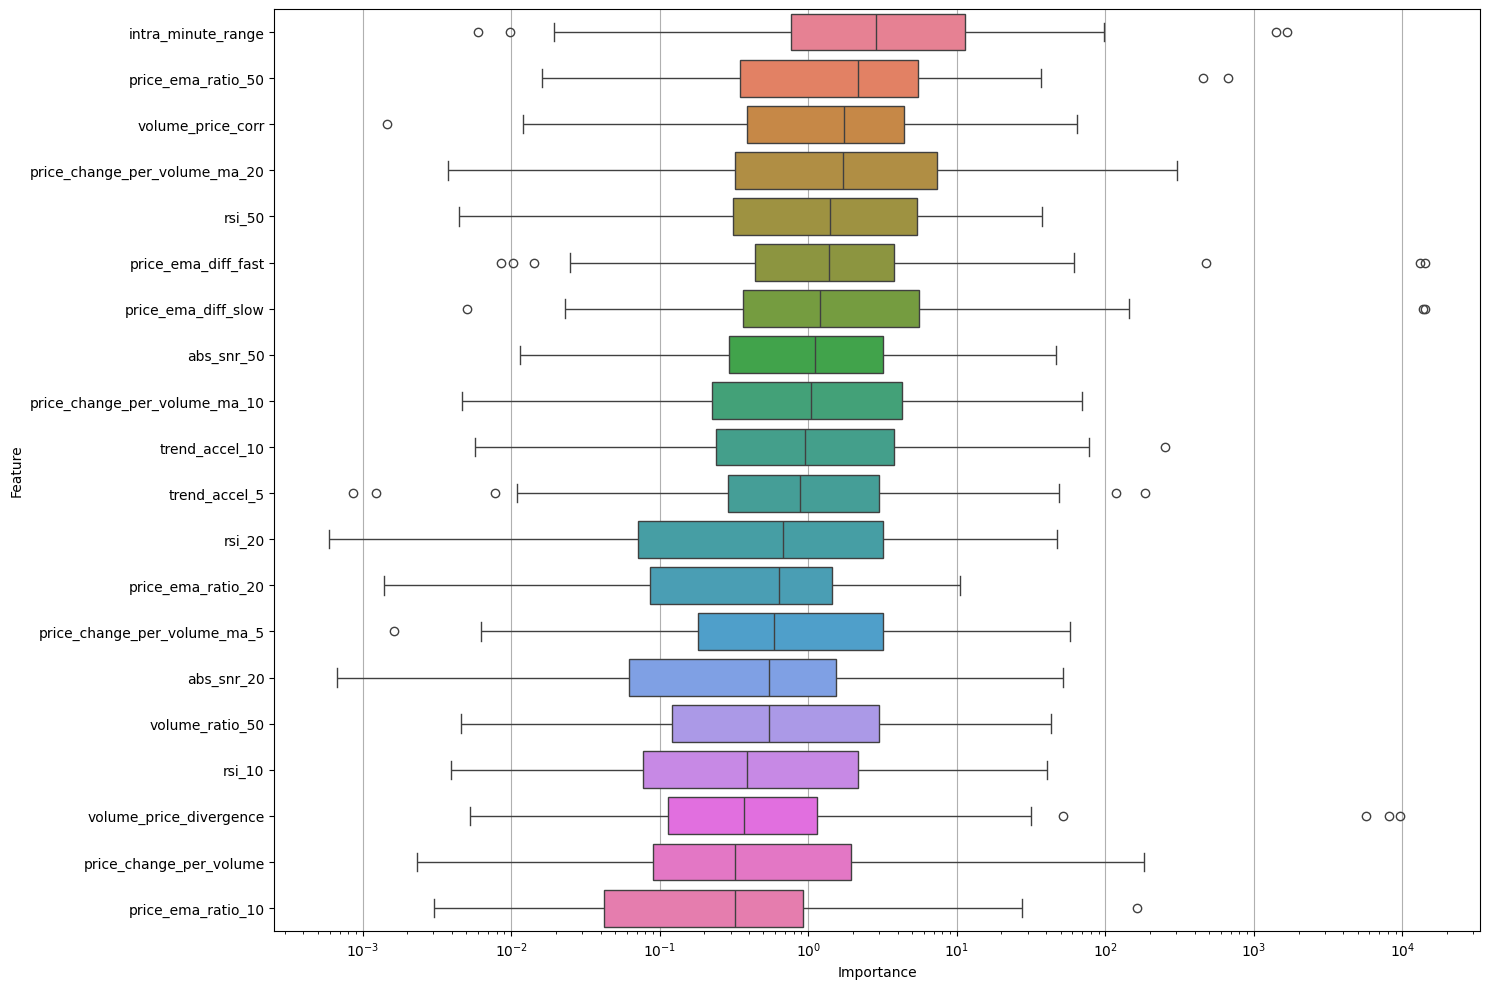

In [ ]:
plot_importance(np.array(all_importances), features, top=20, figsize=(15, 10), save_path=None)

In [ ]:
ic_ls = []
y_valid = factor.loc[factor['train_flg']==1, ['Asset_ID','Target']]
for id in tqdm(range(14)):
    x_valid = X_valid[X_valid['Asset_ID']==id]
    # x_valid_num_scaled = scaler.transform(x_valid[num_cols])
    # x_valid_scaled = pd.DataFrame(x_valid_num_scaled, columns=num_cols, index=x_valid.index)
    # x_valid_scaled = pd.concat([x_valid_scaled, x_valid[cat_cols]], axis=1)
    x_valid_scaled = x_valid
    y_true = y_valid.loc[y_valid['Asset_ID']==id, 'Target'].to_numpy()
    y_pred = model.predict(x_valid_scaled)
    ic = np.corrcoef(y_true, y_pred)[0,1]
    ic_ls.append(ic)
print(np.mean(ic))

  0%|          | 0/14 [00:00<?, ?it/s]


NameError: name 'X_valid' is not defined

In [ ]:
y_test_pred_ensemble

,Asset_ID,Target
timestamp,,
2021-12-03 00:00:00,0,-0.000433
2021-12-03 00:01:00,0,-0.000043
2021-12-03 00:02:00,0,-0.000214
2021-12-03 00:03:00,0,-0.000812
2021-12-03 00:04:00,0,-0.000414
...,...,...
2022-01-23 23:40:00,0,0.001346
2022-01-23 23:41:00,0,0.000856
2022-01-23 23:42:00,0,0.001087
